# Import important libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets.mnist import load_data
import time
from tensorflow.keras import optimizers


In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape 28x28 images to add a channel dimension
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert pixel values to float32 and Normalize pixel values to the range [0, 1]
x_train = x_train.astype("float32") /255.0
x_test = x_test.astype("float32") / 255.0


# Convert data into TensorFlow Dataset objects for batching
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)  # Training dataset in batches
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)    # Test dataset in batches

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = tf.keras.Sequential([
    # Input layer
    layers.Input(shape=(28, 28, 1)),

    # 1st hidden layer
    layers.Conv2D(32, kernel_size=(3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    # layers.Dropout(0.25),

    # 2nd hidden layer
    layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    # layers.Dropout(0.25),

    # 3rd hidden layer
    layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    # layers.Dropout(0.5),

    # Flatten the 3D output to a 1D vector
    layers.Flatten(),
    # layers.Dense(64, activation="relu"),
    # layers.BatchNormalization(),
    # Output layer
    layers.Dense(10, activation="softmax")
])


model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,858 (370.54 KB)

 Trainable params: 94,410 (368.79 KB)

 Non-trainable params: 448 (1.75 KB)

# Implementing tf.GradientTape()

In [ ]:
# Loss function: SparseCategoricalCrossentropy (for multi-class classification with integer labels)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Optimizer: Adam (updates weights using gradients)
optimizer = tf.keras.optimizers.Adam()

# Metrics: track accuracy and loss for training and validation
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
train_loss_metric = tf.keras.metrics.Mean()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_loss_metric = tf.keras.metrics.Mean()


In [ ]:
# Store metrics per epoch
train_loss_history = []
train_acc_history = []
test_acc_history = []
test_loss_history = []

# Record start time
custom_start_time = time.time()

In [ ]:
epochs = 10  # Number of epochs to train the model

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")  # Display current epoch number

    # -----------------------------
    # Reset metrics at the start of the epoch
    # -----------------------------
    train_acc_metric.reset_state()  # Reset training accuracy
    train_loss_metric.reset_state() # Reset training loss
    val_acc_metric.reset_state()    # Reset validation/test accuracy
    val_loss_metric.reset_state()   # Reset validation/test loss

    # -----------------------------
    # Training loop over batches
    # -----------------------------
    for step, (x_batch, y_batch) in enumerate(train_ds):  # Iterate over training batches
        with tf.GradientTape() as tape:  # Start recording gradients
            tape.watch(x_batch)  # track input
            predictions = model(x_batch, training=True)  # Forward pass: compute predictions
            loss = loss_fn(y_batch, predictions)        # Compute loss for this batch

        # -----------------------------
        # Backward pass and weights update
        # -----------------------------
        gradients = tape.gradient(loss, model.trainable_variables)  # Compute gradients
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Update weights

        # -----------------------------
        # Update training metrics
        # -----------------------------
        train_acc_metric.update_state(y_batch, predictions)  # Update training accuracy
        train_loss_metric.update_state(loss)                 # Update training loss

        # Print metrics every 500 steps
        if step % 500 == 0:
            print(f"Step {step+1}/{len(train_ds)} - "
                  f"loss: {train_loss_metric.result().numpy():.4f} - "
                  f"accuracy: {train_acc_metric.result().numpy():.4f}")

    # -----------------------------
    # Validation loop (no gradient updates)
    # -----------------------------
    for x_val, y_val in test_ds:  # Iterate over validation/test batches
        val_predictions = model(x_val, training=False)  # Forward pass
        val_loss = loss_fn(y_val, val_predictions)     # Compute loss
        val_acc_metric.update_state(y_val, val_predictions)  # Update validation accuracy
        val_loss_metric.update_state(val_loss)              # Update validation loss

    # -----------------------------
    # Store epoch-level metrics for plotting
    # -----------------------------
    train_loss_history.append(train_loss_metric.result().numpy())  # Training loss
    train_acc_history.append(train_acc_metric.result().numpy())    # Training accuracy
    test_acc_history.append(val_acc_metric.result().numpy())       # Validation/test accuracy
    test_loss_history.append(val_loss_metric.result().numpy())     # Validation/test loss

    # -----------------------------
    # Print summary of the epoch
    # -----------------------------
    print(f"Epoch {epoch+1} - "
          f"loss: {train_loss_metric.result().numpy():.4f} - "
          f"accuracy: {train_acc_metric.result().numpy():.4f} - "
          f"val_loss: {val_loss_metric.result().numpy():.4f} - "
          f"val_accuracy: {val_acc_metric.result().numpy():.4f}")

# -----------------------------
# Total time taken for training
# -----------------------------
custom_time = time.time() - custom_start_time
print(f"\nTotal training time (custom loop): {custom_time:.2f} seconds")


Epoch 1/10
Step 1/469 - loss: 2.3129 - accuracy: 0.1250
Epoch 1 - loss: 0.2279 - accuracy: 0.9499 - val_loss: 2.7384 - val_accuracy: 0.2888

Epoch 2/10
Step 1/469 - loss: 0.0628 - accuracy: 0.9766
Epoch 2 - loss: 0.0515 - accuracy: 0.9865 - val_loss: 0.0978 - val_accuracy: 0.9684

Epoch 3/10
Step 1/469 - loss: 0.0297 - accuracy: 1.0000
Epoch 3 - loss: 0.0329 - accuracy: 0.9913 - val_loss: 0.0377 - val_accuracy: 0.9882

Epoch 4/10
Step 1/469 - loss: 0.0224 - accuracy: 1.0000
Epoch 4 - loss: 0.0232 - accuracy: 0.9942 - val_loss: 0.0391 - val_accuracy: 0.9879

Epoch 5/10
Step 1/469 - loss: 0.0251 - accuracy: 1.0000
Epoch 5 - loss: 0.0157 - accuracy: 0.9965 - val_loss: 0.0485 - val_accuracy: 0.9847

Epoch 6/10
Step 1/469 - loss: 0.0142 - accuracy: 1.0000
Epoch 6 - loss: 0.0106 - accuracy: 0.9982 - val_loss: 0.0363 - val_accuracy: 0.9880

Epoch 7/10
Step 1/469 - loss: 0.0062 - accuracy: 1.0000
Epoch 7 - loss: 0.0073 - accuracy: 0.9989 - val_loss: 0.0694 - val_accuracy: 0.9772

Epoch 8/10
S

In [ ]:
# Reset metrics
val_acc_metric.reset_state()
val_loss_metric.reset_state()

# Compute final test metrics
for x_val, y_val in test_ds:
    val_predictions = model(x_val, training=False)
    val_loss = loss_fn(y_val, val_predictions)
    val_acc_metric.update_state(y_val, val_predictions)
    val_loss_metric.update_state(val_loss)

# Print final results
print("\nFinal Test Loss:", val_loss_metric.result().numpy())
print("Final Test Accuracy:", val_acc_metric.result().numpy())


Final Test Loss: 0.1366061
Final Test Accuracy: 0.9621


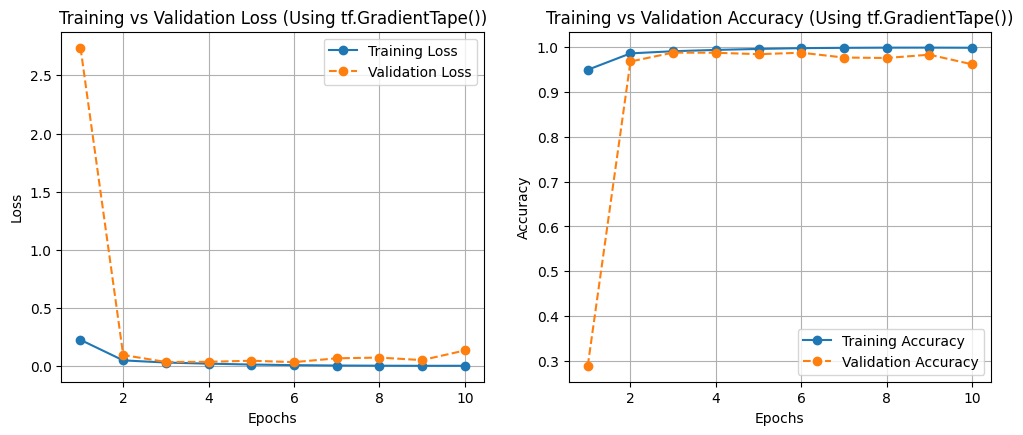

In [ ]:
plt.figure(figsize=(12,10))

# -------- GradientTape --------
# Loss
plt.subplot(2,2,1)
plt.plot(range(1, epochs+1), train_loss_history, marker='o', label='Training Loss')
plt.plot(range(1, epochs+1), test_loss_history, marker='o', linestyle='--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Using tf.GradientTape())')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2,2,2)
plt.plot(range(1, epochs+1), train_acc_history, marker='o', label='Training Accuracy')
plt.plot(range(1, epochs+1), test_acc_history, marker='o', linestyle='--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Using tf.GradientTape())')
plt.legend()
plt.grid(True)

# Train the same model using model.fit (for comparison)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model_fit = tf.keras.Sequential([
    # Input layer
    layers.Input(shape=(28, 28, 1)),

    # 1st hidden layer
    layers.Conv2D(32, kernel_size=(3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    # layers.Dropout(0.25),

    # 2nd hidden layer
    layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    # layers.Dropout(0.25),

    # 3rd hidden layer
    layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    # layers.Dropout(0.5),

    # Flatten the 3D output to a 1D vector
    layers.Flatten(),
    # layers.Dense(64, activation="relu"),
    # layers.BatchNormalization(),
    # Output layer
    layers.Dense(10, activation="softmax")
])

model_fit.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,858 (370.54 KB)

 Trainable params: 94,410 (368.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model_fit.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Starting model.fit training...")

Starting model.fit training...


In [ ]:
start_time = time.time()
history = model_fit.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=128)
fit_time = time.time() - start_time
print("model.fit finished in {:.2f} sec".format(fit_time))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6880 - loss: 1.2686 - val_accuracy: 0.6387 - val_loss: 1.1463
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9526 - loss: 0.2921 - val_accuracy: 0.9679 - val_loss: 0.1768
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9691 - loss: 0.1639 - val_accuracy: 0.9748 - val_loss: 0.1204
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9751 - loss: 0.1178 - val_accuracy: 0.9795 - val_loss: 0.0934
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9802 - loss: 0.0911 - val_accuracy: 0.9807 - val_loss: 0.0782
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9834 - loss: 0.0737 - val_accuracy: 0.9820 - val_loss: 0.0692
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9856 - loss: 0.0638 - val_accuracy: 0.9855 - val_loss: 0.0592
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9869 - loss: 0.0545 - val_accuracy: 

In [ ]:
# Compare metrics
fit_train_loss = history.history['loss']
fit_val_loss = history.history['val_loss']
fit_train_acc  = history.history['accuracy']
fit_val_acc    = history.history['val_accuracy']


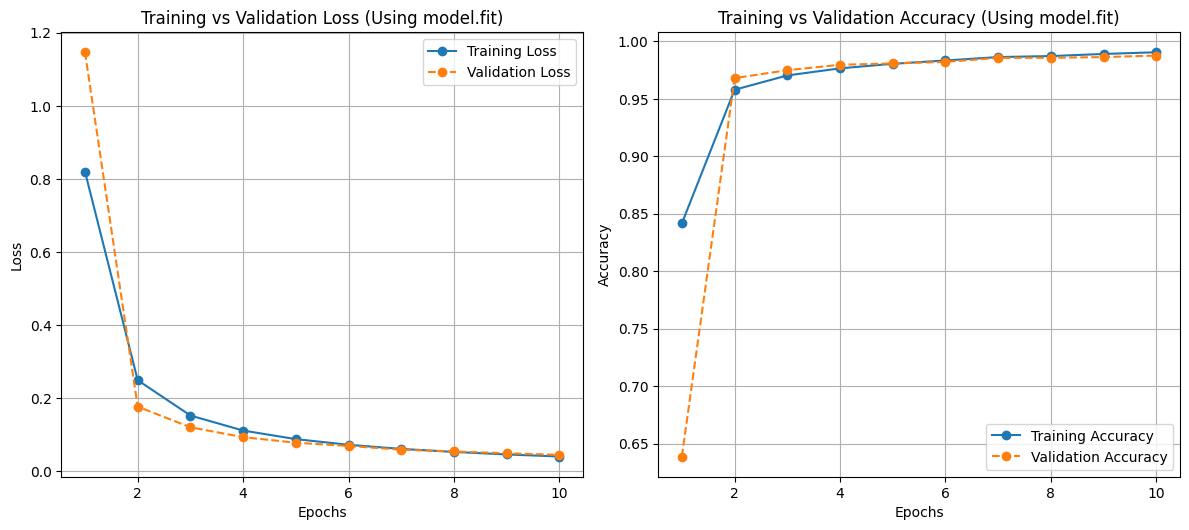

In [ ]:
# -------- model.fit --------
# Loss

plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(range(1, len(fit_train_loss)+1), fit_train_loss, marker='o', label='Training Loss')
plt.plot(range(1, len(fit_val_loss)+1), fit_val_loss, marker='o', linestyle='--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Using model.fit)')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2,2,2)
plt.plot(range(1, len(fit_train_acc)+1), fit_train_acc, marker='o', label='Training Accuracy')
plt.plot(range(1, len(fit_val_acc)+1), fit_val_acc, marker='o', linestyle='--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Using model.fit)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# small function to compute confusion matrix (optional)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


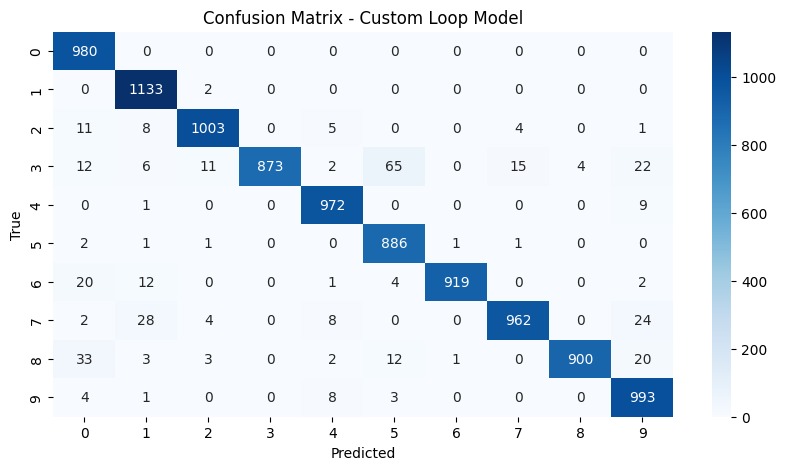

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# plt.figure(figsize=(12,5))

# -----------------------------
# Predictions for custom loop model
# -----------------------------
y_pred_custom = model.predict(x_test)
y_pred_custom_classes = y_pred_custom.argmax(axis=1)

cm_custom = confusion_matrix(y_test, y_pred_custom_classes)
plt.figure(figsize=(10,5))
# plt.subplot(1, 2, 1)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Custom Loop Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


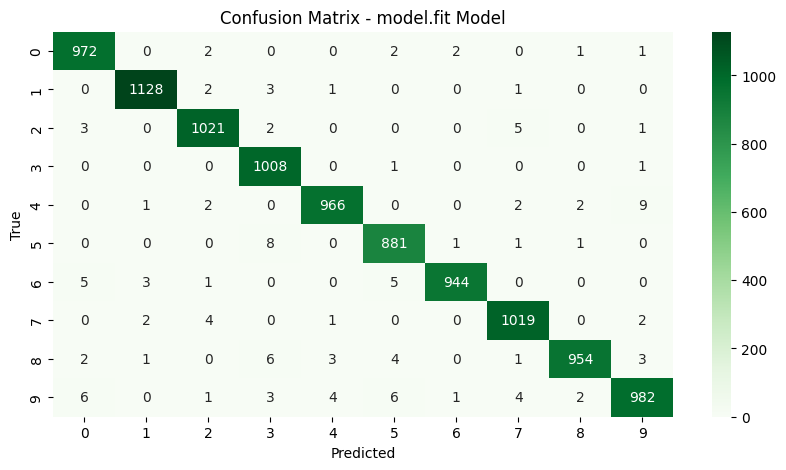

In [ ]:
# -----------------------------
# Predictions for model.fit model
# -----------------------------
y_pred_fit = model_fit.predict(x_test)
y_pred_fit_classes = y_pred_fit.argmax(axis=1)

cm_fit = confusion_matrix(y_test, y_pred_fit_classes)
plt.figure(figsize=(10,5))
# plt.subplot(1, 2, 2)
sns.heatmap(cm_fit, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - model.fit Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from tabulate import tabulate

# Results from custom loop
custom_results = {
    "Train Loss": train_loss_history[-1],
    "Train Accuracy": train_acc_history[-1],
    "Validation Loss": test_loss_history[-1],  # corrected
    "Validation Accuracy": test_acc_history[-1],
    "Time (s)": custom_time
}

# Results from model.fit
fit_results = {
    "Train Loss": fit_train_loss[-1],
    "Train Accuracy": fit_train_acc[-1],
    "Validation Loss": fit_val_loss[-1],
    "Validation Accuracy": fit_val_acc[-1],
    "Time (s)": fit_time
}

# Create comparison table
table = [
    ["tf.GradientTape()",
     f"{custom_results['Train Loss']:.4f}",
     f"{custom_results['Train Accuracy']:.4f}",
     f"{custom_results['Validation Loss']:.4f}",
     f"{custom_results['Validation Accuracy']:.4f}",
     f"{custom_results['Time (s)']:.2f}"],

    ["model.fit()",
     f"{fit_results['Train Loss']:.4f}",
     f"{fit_results['Train Accuracy']:.4f}",
     f"{fit_results['Validation Loss']:.4f}",
     f"{fit_results['Validation Accuracy']:.4f}",
     f"{fit_results['Time (s)']:.2f}"]
]

headers = ["Method", "Train Loss", "Train Accuracy", "Valdation Loss", "Val Accuracy", "Time (s)"]

print(tabulate(table, headers=headers, tablefmt="grid"))


+-------------------+--------------+------------------+------------------+----------------+------------+
| Method            |   Train Loss |   Train Accuracy |   Valdation Loss |   Val Accuracy |   Time (s) |
+===================+==============+==================+==================+================+============+
| tf.GradientTape() |       0.0052 |           0.9991 |           0.1366 |         0.9621 |     569.79 |
+-------------------+--------------+------------------+------------------+----------------+------------+
| model.fit()       |       0.0404 |           0.9904 |           0.0449 |         0.9875 |      52.35 |
+-------------------+--------------+------------------+------------------+----------------+------------+
